In [1]:
import numpy as np
import pandas as pd
import gc
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

In [2]:
df = pd.read_pickle("/Users/chienan/Pycon/github/SportLottery/input/FEATURE_AGG_2012TO2019.pkl")

In [3]:
[col for col in df.columns if "LAST_" not in col]

['GAME_ID',
 'TEAM_ID_HOME',
 'TEAM_ID_AWAY',
 'PLUS_MINUS',
 'GAME_DATE',
 'TEAM_ID_H',
 'TEAM_ID_A',
 'TRAVEL_DISTANCE_H',
 'TRAVEL_DISTANCE_A']

In [4]:
len([col for col in df.columns if "_H" in col])

363

In [5]:
len([col for col in df.columns if ("_A" in col) & ("_H" not in col)])

363

In [6]:
set(df.columns) - set([col for col in df.columns if "_H" in col]) - set([col for col in df.columns if ("_A" in col) & ("_H" not in col)])

{'GAME_DATE', 'GAME_ID', 'PLUS_MINUS'}

In [7]:
df["TEAM_ID_AWAY"] = df["TEAM_ID_AWAY"].astype("category")
df["TEAM_ID_HOME"] = df["TEAM_ID_HOME"].astype("category")

In [8]:
column = ["_".join(col.split("_")[2:-1]) for col in df.columns if ("LAST_1_" in col)&("_H" in col)]

In [10]:
df.loc[df[df.loc[:,"PLUS_MINUS"]>0].index,"PLUS_MINUS"] = 1
df.loc[df[df.loc[:,"PLUS_MINUS"]<0].index,"PLUS_MINUS"] = 0

In [11]:
new_col = []
for col_i in column:
    new_col += [col for col in df.columns if col_i in col]

In [15]:
new_col = list(set(df.columns)-set(new_col))+list(new_col)

In [16]:
len(set(new_col))

729

In [17]:
df = df[new_col]

In [20]:
df.drop(["TEAM_ID_H","TEAM_ID_A"],axis=1,inplace=True)

In [22]:
df_train = df[df.GAME_ID<"0021700000"].reset_index(drop=True)
df_val = df[(df.GAME_ID<"0021800000")&(df.GAME_ID>"0021700000")].reset_index(drop=True)

In [23]:
x_train = df_train.loc[:, [col for col in df_train.columns if (col not in ["GAME_ID","GAME_DATE","PLUS_MINUS"])]]
x_val = df_val.loc[:, [col for col in df_val.columns if (col not in ["GAME_ID","GAME_DATE","PLUS_MINUS"])]]
y_train = df_train.loc[:, "PLUS_MINUS"]
y_val = df_val.loc[:, "PLUS_MINUS"]

In [24]:
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_val, y_val)

In [26]:
def lgb_eval(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    evals_result = {}
    params = {'objective':'binary','num_iterations': 1000, 'early_stopping_round':100, 'metric':'binary_error'}
    
    params["num_leaves"] = int(round(num_leaves))
    params["learning_rate"] = max(learning_rate, 0)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    result = lgb.train(train_set=train_dataset,valid_sets=[train_dataset, test_dataset] ,evals_result=evals_result,
                       params=params,verbose_eval =200)
    return -min(evals_result['valid_1']['binary_error'])

lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.1),
                                        'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.5, 1),
                                        'max_depth': (4, 9),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=7)

In [27]:
%%time
lgbBO.maximize(init_points=50, n_iter=75)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[27]	training's binary_error: 0.217722	valid_1's binary_error: 0.370732
|  1        | -0.3707   |  0.5382   |  0.7239   |  2.192    |  2.17     |  0.09782  |  6.692    |  27.55    |  0.008133 |  29.64    |
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.283813	valid_1's binary_error: 0.377236
Early stopping, best iteration is:
[183]	training's binary_error: 0.287323	valid_1's binary_error: 0.371545
|  2        | -0.3715   |  0.7499   |  0.6434   |  4.019    |  1.143    |  0.007528 |  5.441    |  45.93    |  0.02213  |  33.49    |
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.231613	valid_1's binary_error: 0.357724
Early stopping, best iteration is:
[201]	training's binary_error: 0.231905	valid_1's binary_error: 0.356098
|  3        | -0.3561   |  0.9656   |  0.1199   |  3.003    |  2.85     | 

[200]	training's binary_error: 0.190525	valid_1's binary_error: 0.357724
Early stopping, best iteration is:
[173]	training's binary_error: 0.203685	valid_1's binary_error: 0.354472
|  21       | -0.3545   |  0.7675   |  0.3536   |  3.685    |  0.4806   |  0.02006  |  5.773    |  22.03    |  0.02142  |  43.29    |
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	training's binary_error: 0.230151	valid_1's binary_error: 0.35122
|  22       | -0.3512   |  0.914    |  0.1855   |  1.847    |  0.698    |  0.04566  |  5.382    |  27.58    |  0.09234  |  32.03    |
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	training's binary_error: 0.213189	valid_1's binary_error: 0.369919
|  23       | -0.3699   |  0.8251   |  0.5765   |  3.76     |  0.185    |  0.07474  |  8.731    |  32.16    |  0.02947  |  38.12    |
Training until validation scores don't improve for 100 rounds.
Early stopping,

[400]	training's binary_error: 0.149145	valid_1's binary_error: 0.368293
Early stopping, best iteration is:
[395]	training's binary_error: 0.150022	valid_1's binary_error: 0.365854
|  40       | -0.3659   |  0.5141   |  0.51     |  3.964    |  2.204    |  0.01171  |  8.165    |  15.7     |  0.08097  |  34.44    |
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	training's binary_error: 0.210703	valid_1's binary_error: 0.377236
|  41       | -0.3772   |  0.5804   |  0.6872   |  4.04     |  2.097    |  0.09652  |  5.281    |  15.61    |  0.01558  |  35.33    |
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  42       | -0.4236   |  0.6997   |  0.3853   |  2.302    |  0.8236   |  0.001422 |  6.359    |  17.41    |  0.04553  |  43.51    |
Training until validation scores don't improve for 100 rounds.
Early stopping,

/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	training's binary_error: 0.191841	valid_1's binary_error: 0.35935
|  51       | -0.3593   |  0.5      |  0.1      |  5.0      |  3.0      |  0.1      |  9.0      |  5.0      |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	training's binary_error: 0.192864	valid_1's binary_error: 0.350407
|  52       | -0.3504   |  0.5155   |  0.1      |  0.0      |  2.707    |  0.07217  |  8.533    |  5.0      |  0.08676  |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.298143	valid_1's binary_error: 0.37561
Early stopping, best iteration is:
[236]	training's binary_error: 0.28703	valid_1's binary_error: 0.36748
|  53       | -0.3675   |  0.7248   |  0.4191   |  1.183    |  2.721    |  0.005237 |  8.199    |  49.95    |  0.02335  |  44.47    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.154262	valid_1's binary_error: 0.34878
Early stopping, best iteration is:
[189]	training's binary_error: 0.162451	valid_1's binary_error: 0.34878
|  54       | -0.3488   |  0.8726   |  0.2226   |  0.1552   |  2.856    |  0.0173   |  8.799    |  6.369    |  0.03274  |  36.9     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	training's binary_error: 0.259687	valid_1's binary_error: 0.349593
|  55       | -0.3496   |  0.7598   |  0.1      |  3.517    |  2.483e-1 |  0.1      |  4.0      |  5.0      |  0.02625  |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	training's binary_error: 0.282351	valid_1's binary_error: 0.362602
|  56       | -0.3626   |  0.8995   |  0.4781   |  4.495    |  2.745    |  0.05641  |  4.302    |  49.52    |  0.04873  |  44.74    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	training's binary_error: 0.210703	valid_1's binary_error: 0.339837
|  57       | -0.3398   |  0.5      |  0.1      |  5.0      |  3.0      |  0.1      |  9.0      |  26.26    |  0.1      |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.119754	valid_1's binary_error: 0.365854
Early stopping, best iteration is:
[111]	training's binary_error: 0.200468	valid_1's binary_error: 0.350407
|  58       | -0.3504   |  1.0      |  0.1      |  4.352    |  3.0      |  0.1      |  4.0      |  5.0      |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.108934	valid_1's binary_error: 0.34878
Early stopping, best iteration is:
[107]	training's binary_error: 0.188332	valid_1's binary_error: 0.343089
|  59       | -0.3431   |  0.6951   |  0.1901   |  4.665    |  0.8373   |  0.1      |  4.0      |  5.0      |  0.1      |  36.22    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.170639	valid_1's binary_error: 0.361789
Early stopping, best iteration is:
[112]	training's binary_error: 0.229127	valid_1's binary_error: 0.344715
|  60       | -0.3447   |  0.9992   |  0.1      |  5.0      |  3.0      |  0.1      |  4.0      |  41.83    |  0.09996  |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	training's binary_error: 0.28703	valid_1's binary_error: 0.356098
|  61       | -0.3561   |  0.5096   |  0.2907   |  0.04395  |  0.3292   |  0.08538  |  4.233    |  23.52    |  0.09386  |  24.13    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	training's binary_error: 0.223132	valid_1's binary_error: 0.358537
|  62       | -0.3585   |  0.8905   |  0.2226   |  0.05418  |  2.822    |  0.04443  |  4.589    |  5.459    |  0.05077  |  32.14    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	training's binary_error: 0.218745	valid_1's binary_error: 0.353659
|  63       | -0.3537   |  0.8776   |  0.1534   |  0.9382   |  0.3195   |  0.05075  |  8.991    |  5.068    |  0.09104  |  29.12    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0880246	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[112]	training's binary_error: 0.164644	valid_1's binary_error: 0.336585
|  64       | -0.3366   |  1.0      |  0.1      |  5.0      |  3.0      |  0.1      |  9.0      |  50.0     |  0.1      |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	training's binary_error: 0.283521	valid_1's binary_error: 0.357724
|  65       | -0.3577   |  0.821    |  0.1358   |  4.936    |  2.861    |  0.04897  |  4.33     |  22.95    |  0.09231  |  42.81    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	training's binary_error: 0.190964	valid_1's binary_error: 0.343089
|  66       | -0.3431   |  1.0      |  0.1      |  5.0      |  0.0      |  0.1      |  9.0      |  50.0     |  0.001    |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.282936	valid_1's binary_error: 0.37561
Early stopping, best iteration is:
[116]	training's binary_error: 0.302091	valid_1's binary_error: 0.371545
|  67       | -0.3715   |  0.735    |  0.3677   |  4.894    |  0.05429  |  0.0118   |  4.034    |  31.59    |  0.04243  |  24.08    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.101477	valid_1's binary_error: 0.350407
Early stopping, best iteration is:
[266]	training's binary_error: 0.0600965	valid_1's binary_error: 0.339837
|  68       | -0.3398   |  0.7264   |  0.2029   |  4.414    |  0.1221   |  0.052    |  8.496    |  11.63    |  0.001971 |  24.34    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	training's binary_error: 0.254277	valid_1's binary_error: 0.352033
|  69       | -0.352    |  0.5488   |  0.1223   |  4.032    |  1.175    |  0.0807   |  4.232    |  49.43    |  0.004353 |  24.26    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	training's binary_error: 0.15163	valid_1's binary_error: 0.344715
|  70       | -0.3447   |  0.9048   |  0.1      |  4.474    |  3.0      |  0.1      |  9.0      |  37.38    |  0.001    |  24.53    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.25998	valid_1's binary_error: 0.364228
Early stopping, best iteration is:
[162]	training's binary_error: 0.270507	valid_1's binary_error: 0.353659
|  71       | -0.3537   |  0.6843   |  0.227    |  0.3467   |  0.2315   |  0.02513  |  4.142    |  49.82    |  0.02273  |  44.87    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0851002	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[151]	training's binary_error: 0.126773	valid_1's binary_error: 0.343089
|  72       | -0.3431   |  0.8762   |  0.1514   |  0.2952   |  2.857    |  0.03649  |  8.993    |  15.54    |  0.08812  |  35.42    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[73]	training's binary_error: 0.182044	valid_1's binary_error: 0.352846
|  73       | -0.3528   |  0.7905   |  0.1715   |  4.785    |  2.505    |  0.05192  |  8.878    |  11.05    |  0.006169 |  39.72    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.152946	valid_1's binary_error: 0.365854
Early stopping, best iteration is:
[108]	training's binary_error: 0.216113	valid_1's binary_error: 0.358537
|  74       | -0.3585   |  0.6124   |  0.539    |  4.636    |  0.3529   |  0.03155  |  8.376    |  5.215    |  0.09564  |  24.16    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	training's binary_error: 0.174733	valid_1's binary_error: 0.349593
|  75       | -0.3496   |  0.9875   |  0.1503   |  4.948    |  0.001274 |  0.09308  |  8.717    |  48.88    |  0.06257  |  40.92    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0644831	valid_1's binary_error: 0.356098
Early stopping, best iteration is:
[160]	training's binary_error: 0.0967978	valid_1's binary_error: 0.343089
|  76       | -0.3431   |  0.6914   |  0.1144   |  4.218    |  0.4723   |  0.05197  |  8.658    |  24.12    |  0.09193  |  44.99    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.169031	valid_1's binary_error: 0.364228
Early stopping, best iteration is:
[122]	training's binary_error: 0.220061	valid_1's binary_error: 0.355285
|  77       | -0.3553   |  0.5      |  0.1      |  0.4317   |  1.237e-0 |  0.07252  |  4.0      |  13.74    |  0.09071  |  24.13    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	training's binary_error: 0.225618	valid_1's binary_error: 0.354472
|  78       | -0.3545   |  0.6483   |  0.2093   |  4.683    |  2.829    |  0.05932  |  8.712    |  45.84    |  0.08007  |  24.07    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0625822	valid_1's binary_error: 0.357724
Early stopping, best iteration is:
[143]	training's binary_error: 0.107618	valid_1's binary_error: 0.349593
|  79       | -0.3496   |  0.6305   |  0.1511   |  4.288    |  0.2628   |  0.07506  |  8.611    |  21.75    |  0.07722  |  24.07    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0989911	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[110]	training's binary_error: 0.179851	valid_1's binary_error: 0.34878
|  80       | -0.3488   |  0.978    |  0.102    |  4.712    |  2.876    |  0.04236  |  8.811    |  21.38    |  0.02646  |  44.82    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0195935	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[133]	training's binary_error: 0.0627285	valid_1's binary_error: 0.339837
|  81       | -0.3398   |  0.5      |  0.1      |  5.0      |  0.1372   |  0.1      |  7.777    |  9.011    |  0.001    |  30.44    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.172247	valid_1's binary_error: 0.36748
Early stopping, best iteration is:
[110]	training's binary_error: 0.224156	valid_1's binary_error: 0.355285
|  82       | -0.3553   |  0.9976   |  0.1622   |  0.151    |  2.999    |  0.09518  |  4.282    |  49.8     |  0.09784  |  39.86    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	training's binary_error: 0.236146	valid_1's binary_error: 0.343089
|  83       | -0.3431   |  0.5      |  0.1      |  0.09663  |  0.0      |  0.1      |  4.0      |  37.57    |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  84       | -0.4236   |  0.6281   |  0.1      |  0.0      |  3.0      |  0.001    |  7.612    |  5.0      |  0.001    |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[27]	training's binary_error: 0.292879	valid_1's binary_error: 0.352846
|  85       | -0.3528   |  0.5      |  0.1      |  2.593e-0 |  3.0      |  0.1      |  4.0      |  30.84    |  0.001    |  31.1     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[79]	training's binary_error: 0.101477	valid_1's binary_error: 0.345528
|  86       | -0.3455   |  0.6737   |  0.1972   |  4.962    |  0.1604   |  0.09172  |  8.737    |  5.541    |  0.09062  |  36.79    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0147682	valid_1's binary_error: 0.36748
Early stopping, best iteration is:
[122]	training's binary_error: 0.0693084	valid_1's binary_error: 0.355285
|  87       | -0.3553   |  0.5      |  0.1282   |  0.0      |  2.874    |  0.1      |  8.88     |  13.78    |  0.001    |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.2553	valid_1's binary_error: 0.358537
Early stopping, best iteration is:
[218]	training's binary_error: 0.25106	valid_1's binary_error: 0.355285
|  88       | -0.3553   |  0.8068   |  0.2682   |  4.883    |  0.0825   |  0.02647  |  4.081    |  39.29    |  0.001918 |  42.88    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	training's binary_error: 0.187601	valid_1's binary_error: 0.352033
|  89       | -0.352    |  0.7207   |  0.2608   |  4.884    |  0.03545  |  0.09131  |  8.653    |  31.76    |  0.02099  |  24.43    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0880246	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[112]	training's binary_error: 0.164644	valid_1's binary_error: 0.336585
|  90       | -0.3366   |  1.0      |  0.1      |  5.0      |  3.0      |  0.1      |  9.0      |  50.0     |  0.1      |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	training's binary_error: 0.229858	valid_1's binary_error: 0.346341
|  91       | -0.3463   |  1.0      |  0.1      |  9.551e-0 |  5.731e-0 |  0.1      |  4.0      |  5.579    |  0.0325   |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	training's binary_error: 0.265097	valid_1's binary_error: 0.352033
|  92       | -0.352    |  0.5      |  0.1      |  4.267    |  0.0      |  0.1      |  4.627    |  25.18    |  0.06048  |  29.89    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	training's binary_error: 0.27504	valid_1's binary_error: 0.362602
|  93       | -0.3626   |  0.9677   |  0.3767   |  3.292    |  2.932    |  0.09458  |  4.453    |  5.035    |  0.03653  |  39.43    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	training's binary_error: 0.224887	valid_1's binary_error: 0.347967
|  94       | -0.348    |  0.964    |  0.1      |  2.659    |  0.5603   |  0.05643  |  9.0      |  11.72    |  0.001    |  33.29    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0368475	valid_1's binary_error: 0.373171
Early stopping, best iteration is:
[196]	training's binary_error: 0.0393332	valid_1's binary_error: 0.370732
|  95       | -0.3707   |  0.5      |  0.9      |  5.0      |  2.116e-0 |  0.1      |  9.0      |  50.0     |  0.1      |  45.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.174879	valid_1's binary_error: 0.365854
Early stopping, best iteration is:
[134]	training's binary_error: 0.209095	valid_1's binary_error: 0.356098
|  96       | -0.3561   |  0.7447   |  0.1609   |  0.208    |  2.865    |  0.09231  |  4.268    |  49.72    |  0.02864  |  27.78    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	training's binary_error: 0.221377	valid_1's binary_error: 0.352846
|  97       | -0.3528   |  0.6168   |  0.1165   |  4.654    |  2.588    |  0.09621  |  7.499    |  49.97    |  0.08867  |  37.4     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.00701857	valid_1's binary_error: 0.38374
Early stopping, best iteration is:
[106]	training's binary_error: 0.0669689	valid_1's binary_error: 0.364228
|  98       | -0.3642   |  0.9975   |  0.1725   |  0.1597   |  2.873    |  0.09522  |  8.395    |  23.72    |  0.08602  |  43.31    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	training's binary_error: 0.261734	valid_1's binary_error: 0.368293
|  99       | -0.3683   |  0.7085   |  0.5777   |  4.87     |  0.05749  |  0.08948  |  4.28     |  24.96    |  0.08729  |  44.73    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0640445	valid_1's binary_error: 0.366667
Early stopping, best iteration is:
[176]	training's binary_error: 0.0821758	valid_1's binary_error: 0.355285
|  100      | -0.3553   |  0.8411   |  0.2669   |  4.861    |  0.01102  |  0.0599   |  8.661    |  32.8     |  0.08938  |  44.36    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	training's binary_error: 0.183214	valid_1's binary_error: 0.35935
|  101      | -0.3593   |  0.9999   |  0.2162   |  4.836    |  0.1418   |  0.08754  |  8.92     |  38.22    |  0.06952  |  29.13    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	training's binary_error: 0.309548	valid_1's binary_error: 0.377236
|  102      | -0.3772   |  0.8224   |  0.7125   |  4.916    |  0.1956   |  0.01289  |  4.244    |  5.226    |  0.04644  |  43.36    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0946045	valid_1's binary_error: 0.360163
Early stopping, best iteration is:
[126]	training's binary_error: 0.150899	valid_1's binary_error: 0.347967
|  103      | -0.348    |  0.6707   |  0.1347   |  4.986    |  2.792    |  0.09294  |  8.057    |  49.97    |  0.05364  |  28.96    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	training's binary_error: 0.209387	valid_1's binary_error: 0.356098
|  104      | -0.3561   |  0.7194   |  0.1064   |  0.2705   |  2.94     |  0.09652  |  5.699    |  10.37    |  0.01482  |  37.53    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.118585	valid_1's binary_error: 0.365854
Early stopping, best iteration is:
[100]	training's binary_error: 0.200029	valid_1's binary_error: 0.347967
|  105      | -0.348    |  0.7919   |  0.1026   |  4.937    |  2.833    |  0.06826  |  8.855    |  44.5     |  0.06823  |  44.57    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	training's binary_error: 0.256178	valid_1's binary_error: 0.34878
|  106      | -0.3488   |  0.9965   |  0.3043   |  0.6053   |  0.249    |  0.06549  |  8.743    |  49.77    |  0.02958  |  32.83    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	training's binary_error: 0.211581	valid_1's binary_error: 0.352033
|  107      | -0.352    |  0.9696   |  0.1735   |  0.3406   |  0.2434   |  0.05772  |  8.796    |  40.48    |  0.0217   |  24.31    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	training's binary_error: 0.276649	valid_1's binary_error: 0.354472
|  108      | -0.3545   |  0.9942   |  0.1428   |  1.023    |  2.679    |  0.0942   |  4.249    |  20.96    |  0.06503  |  33.3     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.271677	valid_1's binary_error: 0.360163
Early stopping, best iteration is:
[277]	training's binary_error: 0.253838	valid_1's binary_error: 0.350407
|  109      | -0.3504   |  0.9677   |  0.1421   |  2.504    |  2.951    |  0.01856  |  4.071    |  18.32    |  0.07278  |  24.06    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	training's binary_error: 0.241848	valid_1's binary_error: 0.352846
|  110      | -0.3528   |  0.9413   |  0.1024   |  0.01581  |  2.59     |  0.0718   |  4.173    |  8.395    |  0.03924  |  24.6     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	training's binary_error: 0.288346	valid_1's binary_error: 0.356098
|  111      | -0.3561   |  0.9755   |  0.1856   |  0.1759   |  2.969    |  0.0593   |  4.024    |  24.86    |  0.09919  |  24.21    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	training's binary_error: 0.172247	valid_1's binary_error: 0.360163
|  112      | -0.3602   |  0.9881   |  0.268    |  0.4116   |  0.2094   |  0.07367  |  8.864    |  41.99    |  0.06969  |  44.8     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.0384559	valid_1's binary_error: 0.357724
Early stopping, best iteration is:
[221]	training's binary_error: 0.0276356	valid_1's binary_error: 0.347967
|  113      | -0.348    |  1.0      |  0.1      |  5.0      |  2.822e-0 |  0.1      |  8.958    |  8.099    |  0.001    |  24.0     |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	training's binary_error: 0.227226	valid_1's binary_error: 0.349593
|  114      | -0.3496   |  0.5107   |  0.1355   |  4.946    |  2.722    |  0.06184  |  8.441    |  15.59    |  0.03005  |  24.13    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	training's binary_error: 0.293903	valid_1's binary_error: 0.356911
|  115      | -0.3569   |  0.9913   |  0.1213   |  0.5064   |  0.05831  |  0.05158  |  4.187    |  39.15    |  0.09007  |  37.78    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[16]	training's binary_error: 0.268022	valid_1's binary_error: 0.358537
|  116      | -0.3585   |  0.5      |  0.1      |  0.0      |  0.0      |  0.1      |  5.189    |  5.355    |  0.1      |  34.78    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	training's binary_error: 0.166691	valid_1's binary_error: 0.347154
|  117      | -0.3472   |  0.9715   |  0.1369   |  4.776    |  0.4376   |  0.09335  |  6.653    |  40.65    |  0.02392  |  24.03    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[73]	training's binary_error: 0.156748	valid_1's binary_error: 0.35122
|  118      | -0.3512   |  0.8517   |  0.1145   |  4.816    |  0.015    |  0.09635  |  8.635    |  11.71    |  0.02058  |  27.47    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.115222	valid_1's binary_error: 0.36748
Early stopping, best iteration is:
[105]	training's binary_error: 0.193157	valid_1's binary_error: 0.358537
|  119      | -0.3585   |  0.9659   |  0.1005   |  3.052    |  0.1051   |  0.05096  |  4.519    |  5.74     |  0.001513 |  30.19    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	training's binary_error: 0.22942	valid_1's binary_error: 0.364228
|  120      | -0.3642   |  0.8702   |  0.7554   |  0.2099   |  0.08971  |  0.05269  |  8.227    |  49.25    |  0.04687  |  24.53    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.21275	valid_1's binary_error: 0.364228
Early stopping, best iteration is:
[174]	training's binary_error: 0.221962	valid_1's binary_error: 0.357724
|  121      | -0.3577   |  1.0      |  0.1      |  4.681    |  1.677e-0 |  0.06875  |  4.11     |  50.0     |  0.001    |  38.12    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	training's binary_error: 0.227372	valid_1's binary_error: 0.35122
|  122      | -0.3512   |  0.5665   |  0.1669   |  0.1128   |  2.756    |  0.08097  |  4.551    |  44.53    |  0.08088  |  44.91    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's binary_error: 0.413511	valid_1's binary_error: 0.423577
|  123      | -0.4236   |  1.0      |  0.3446   |  4.741    |  3.0      |  0.001    |  4.0      |  49.27    |  0.1      |  26.62    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	training's binary_error: 0.16172	valid_1's binary_error: 0.365041
|  124      | -0.365    |  0.5055   |  0.8971   |  0.6225   |  2.675    |  0.09265  |  8.844    |  49.97    |  0.04147  |  30.54    |


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's binary_error: 0.309548	valid_1's binary_error: 0.373171
[400]	training's binary_error: 0.283082	valid_1's binary_error: 0.368293
Early stopping, best iteration is:
[309]	training's binary_error: 0.293756	valid_1's binary_error: 0.366667
|  125      | -0.3667   |  0.6382   |  0.1014   |  0.5777   |  0.5352   |  0.005952 |  5.121    |  49.66    |  0.05946  |  24.19    |
CPU times: user 1h 35min 16s, sys: 16min 49s, total: 1h 52min 5s
Wall time: 1h 13min 4s


In [28]:
lgbBO.res[np.argmax([i["target"] for i in lgbBO.res])]

{'params': {'bagging_fraction': 0.9999999999959872,
  'feature_fraction': 0.1,
  'lambda_l1': 4.999999999999391,
  'lambda_l2': 2.9999999999743956,
  'learning_rate': 0.1,
  'max_depth': 8.999999999985075,
  'min_child_weight': 50.0,
  'min_split_gain': 0.09999999999641146,
  'num_leaves': 24.0},
 'target': -0.33658536585365856}

In [49]:
best_params = lgbBO.res[np.argmax([i["target"] for i in lgbBO.res])]["params"]

In [50]:
best_params["num_leaves"] = int(round(best_params["num_leaves"]))
best_params["max_depth"] = int(round(best_params["max_depth"]))
best_params['num_iterations'] = 1000
best_params['early_stopping_round'] = 100
best_params['metric'] = 'binary_error'
best_params['objective'] = 'binary'

In [51]:
best_params

{'bagging_fraction': 0.9999999999959872,
 'early_stopping_round': 100,
 'feature_fraction': 0.1,
 'lambda_l1': 4.999999999999391,
 'lambda_l2': 2.9999999999743956,
 'learning_rate': 0.1,
 'max_depth': 9,
 'metric': 'binary_error',
 'min_child_weight': 50.0,
 'min_split_gain': 0.09999999999641146,
 'num_iterations': 1000,
 'num_leaves': 24,
 'objective': 'binary'}

In [52]:
len(x_train.columns)

46

In [53]:
import pickle

In [54]:
pickle.dump(best_params, open("/Users/chienan/Pycon/github/SportLottery/model/model_feature-724_params.pkl","wb"),protocol=-1)

In [36]:
%%time
evals_result = {}
print("start training...")
model = lgb.train(train_set=train_dataset,
                  valid_sets=[train_dataset, test_dataset] ,
                  verbose_eval=100,
                  params=best_params,
                  evals_result=evals_result)

start training...
Training until validation scores don't improve for 100 rounds.


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's binary_error: 0.178535	valid_1's binary_error: 0.346341
[200]	training's binary_error: 0.0880246	valid_1's binary_error: 0.352846
Early stopping, best iteration is:
[112]	training's binary_error: 0.164644	valid_1's binary_error: 0.336585
CPU times: user 2.95 s, sys: 1.56 s, total: 4.51 s
Wall time: 1.48 s


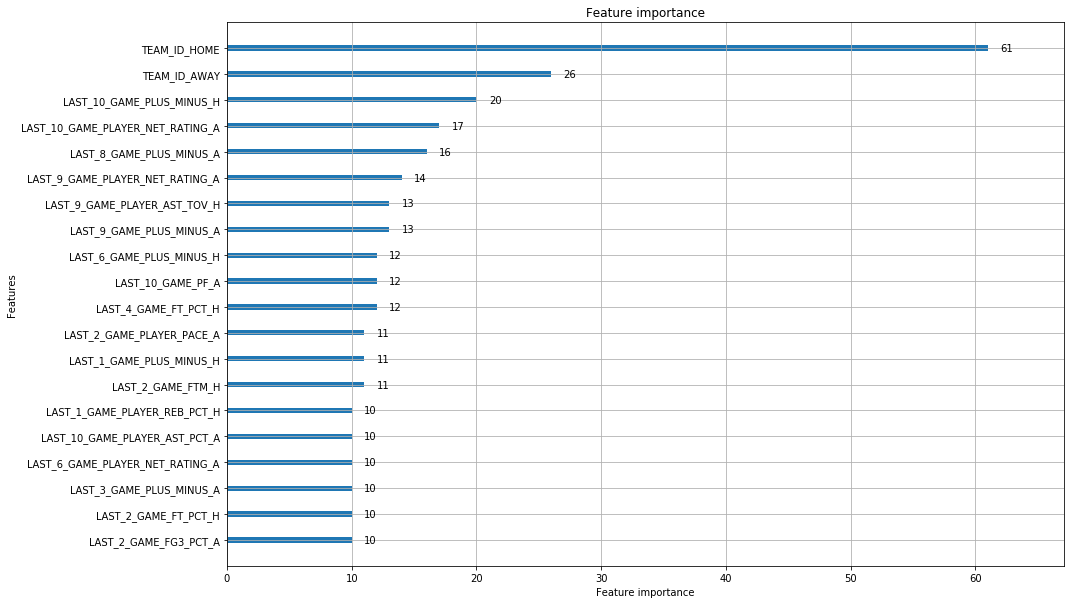

In [37]:
lgb.plot_importance(booster=model,max_num_features=20,importance_type="split",figsize=(15,10))
plt.show()

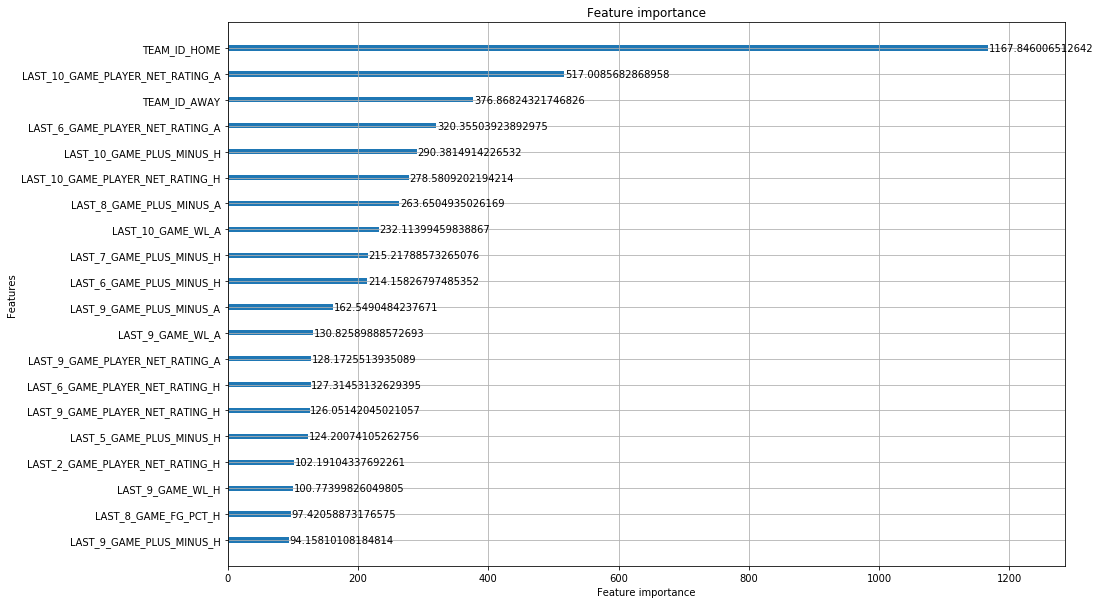

In [38]:
lgb.plot_importance(booster=model,max_num_features=20,importance_type="gain",figsize=(15,10))
plt.show()

In [39]:
np.percentile(model.feature_importance(importance_type="gain"),q=90)

32.30365507602695

In [40]:
np.percentile(model.feature_importance(importance_type="split"),q=90)

6.0

In [41]:
sum(model.feature_importance(importance_type="gain")>
    np.percentile(model.feature_importance(importance_type="gain"),q=90))

73

In [42]:
use_col = x_train.columns[(model.feature_importance(importance_type="gain")>np.percentile(model.feature_importance(importance_type="gain"),q=90))
                         &(model.feature_importance(importance_type="split")>np.percentile(model.feature_importance(importance_type="split"),q=90))]

In [60]:
use_col

Index(['TEAM_ID_HOME', 'TEAM_ID_AWAY', 'LAST_7_GAME_FGA_A',
       'LAST_8_GAME_FG_PCT_H', 'LAST_3_GAME_FG_PCT_A', 'LAST_6_GAME_FG_PCT_A',
       'LAST_8_GAME_FG_PCT_A', 'LAST_2_GAME_FG3_PCT_A',
       'LAST_3_GAME_FG3_PCT_A', 'LAST_2_GAME_FTM_H', 'LAST_2_GAME_FT_PCT_H',
       'LAST_4_GAME_FT_PCT_H', 'LAST_2_GAME_FT_PCT_A', 'LAST_10_GAME_FT_PCT_A',
       'LAST_4_GAME_DREB_H', 'LAST_10_GAME_AST_H', 'LAST_6_GAME_TOV_H',
       'LAST_10_GAME_PF_A', 'LAST_1_GAME_PLUS_MINUS_H',
       'LAST_3_GAME_PLUS_MINUS_H', 'LAST_6_GAME_PLUS_MINUS_H',
       'LAST_9_GAME_PLUS_MINUS_H', 'LAST_10_GAME_PLUS_MINUS_H',
       'LAST_3_GAME_PLUS_MINUS_A', 'LAST_4_GAME_PLUS_MINUS_A',
       'LAST_6_GAME_PLUS_MINUS_A', 'LAST_8_GAME_PLUS_MINUS_A',
       'LAST_9_GAME_PLUS_MINUS_A', 'LAST_2_GAME_PLAYER_MIN_H',
       'LAST_2_GAME_PLAYER_DEF_RATING_A', 'LAST_5_GAME_PLAYER_NET_RATING_H',
       'LAST_9_GAME_PLAYER_NET_RATING_H', 'LAST_10_GAME_PLAYER_NET_RATING_H',
       'LAST_6_GAME_PLAYER_NET_RATING_A', 'LAST_8

In [44]:
x_train = df_train.loc[:, use_col]
x_val = df_val.loc[:, use_col]
y_train = df_train.loc[:, "PLUS_MINUS"]
y_val = df_val.loc[:, "PLUS_MINUS"]

In [45]:
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_val, y_val)

In [46]:
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve

In [55]:
best_params

{'bagging_fraction': 0.9999999999959872,
 'early_stopping_round': 100,
 'feature_fraction': 0.1,
 'lambda_l1': 4.999999999999391,
 'lambda_l2': 2.9999999999743956,
 'learning_rate': 0.1,
 'max_depth': 9,
 'metric': 'binary_error',
 'min_child_weight': 50.0,
 'min_split_gain': 0.09999999999641146,
 'num_iterations': 1000,
 'num_leaves': 24,
 'objective': 'binary'}

In [56]:
%%time
print("start training...")
model_v2 = lgb.train(train_set=train_dataset,
                     valid_sets=[train_dataset, test_dataset] ,
                     verbose_eval=100,
                     params=best_params,
                     evals_result=evals_result)

start training...
Training until validation scores don't improve for 100 rounds.


/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/chienan/anaconda2/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's binary_error: 0.257494	valid_1's binary_error: 0.363415
Early stopping, best iteration is:
[80]	training's binary_error: 0.267875	valid_1's binary_error: 0.35935
CPU times: user 1.05 s, sys: 1.38 s, total: 2.43 s
Wall time: 1.3 s


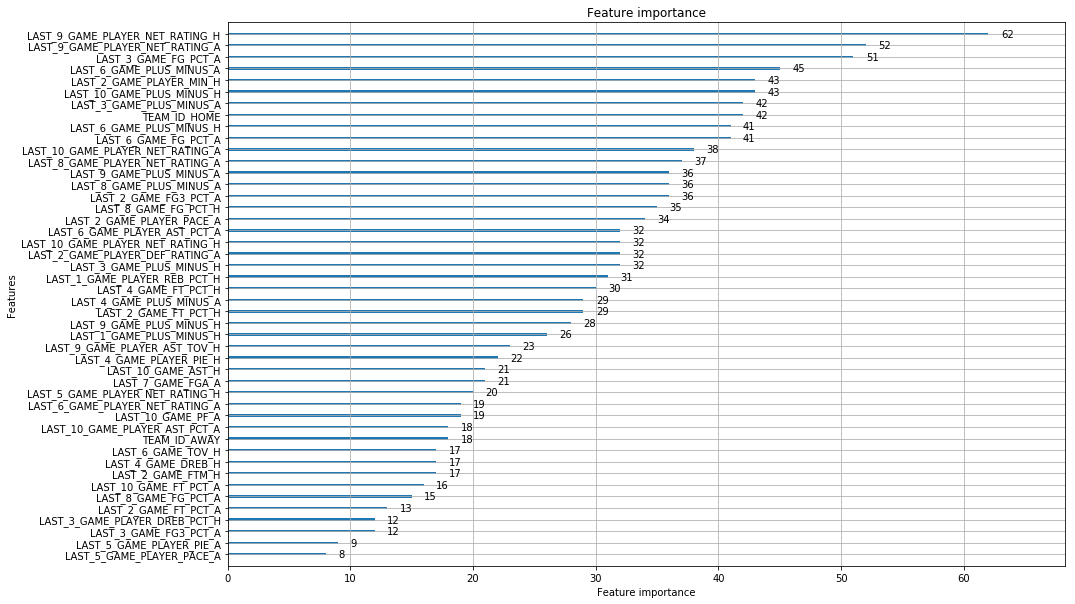

In [62]:
lgb.plot_importance(booster=model_v2,importance_type="split",figsize=(15,10))
plt.show()

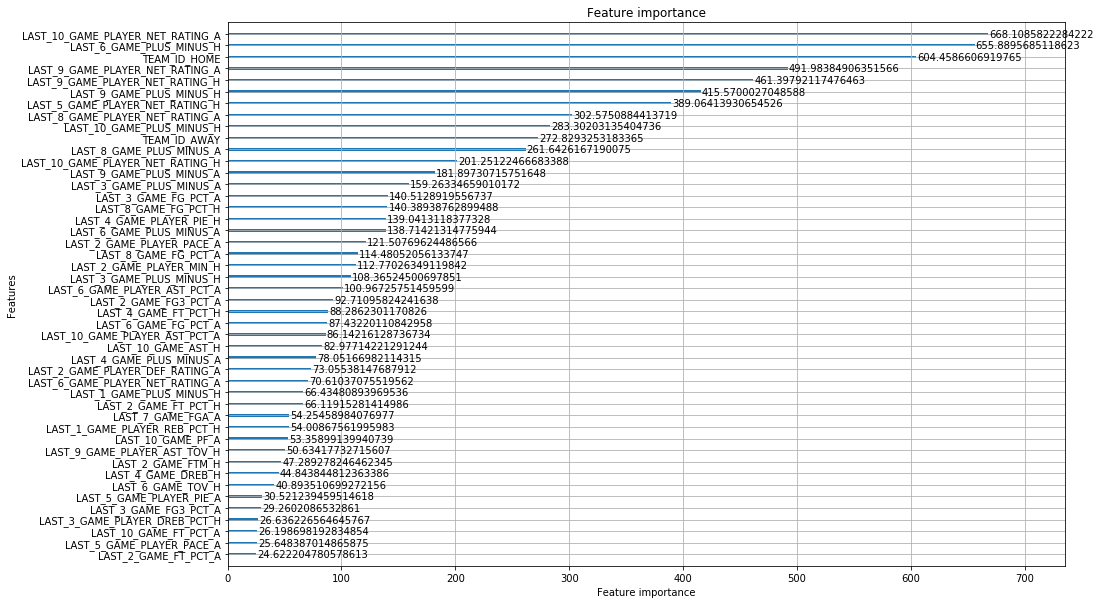

In [63]:
lgb.plot_importance(booster=model_v2,importance_type="gain",figsize=(15,10))
plt.show()

In [59]:
len(x_train.columns)

46

In [64]:
model.save_model('/Users/chienan/Pycon/github/SportLottery/model/classfication_model_feature-46.txt')

In [65]:
pickle.dump(use_col, open("/Users/chienan/Pycon/github/SportLottery/model/model_feature_col-46.pkl","wb"),protocol=-1)